<a href="https://colab.research.google.com/github/YassineSdk/Leaf_classification_transfor_learning_pytorch/blob/main/Model_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Beans leaf Classification using Transform learning in Pytorch**

- in this project we are trying to classify beans leafs using a deep learning Framework Pytorch , but we won't build the model from scratch instead we we use a pretrained model that will take the knowlage from our new data this approch is called  Transfer learning , Transfer learning is a technique in machine learning where a model trained on one task (usually with a large dataset) is reused as the starting point for a model on a new, often related task (often with a smaller dataset). The key idea is that the knowledge (features, weights, etc.) learned from one problem can be applied to another problem.

- This method is particularly helpful when the dataset for the new task is small or lacks sufficient data for training a model from scratch.

### **Loading the data from kaggle using the opendatasets package**

In [1]:
! pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yassinesadiki
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.19GB/s]

### **Importing the packages**

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device )

cuda


In [3]:
"/content/bean-leaf-lesions-classification/train/bean_rust/bean_rust_train.332.jpg"

'/content/bean-leaf-lesions-classification/train/bean_rust/bean_rust_train.332.jpg'

In [4]:
train_df = pd.read_csv('/content/bean-leaf-lesions-classification/train.csv')
val_df = pd.read_csv('/content/bean-leaf-lesions-classification/val.csv')
train_df

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0
...,...,...
1029,train/bean_rust/bean_rust_train.29.jpg,2
1030,train/bean_rust/bean_rust_train.311.jpg,2
1031,train/bean_rust/bean_rust_train.336.jpg,2
1032,train/bean_rust/bean_rust_train.329.jpg,2


In [36]:

path_start = "/content/bean-leaf-lesions-classification/"
val_df['image:FILE'] = path_start + val_df['image:FILE']
val_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/val/...,0
1,/content/bean-leaf-lesions-classification/val/...,0
2,/content/bean-leaf-lesions-classification/val/...,0
3,/content/bean-leaf-lesions-classification/val/...,0
4,/content/bean-leaf-lesions-classification/val/...,0


In [5]:
train_df['image:FILE'] = path_start + train_df['image:FILE']

In [6]:
val_df

,image:FILE,category
0,val/healthy/healthy_val.25.jpg,0
1,val/healthy/healthy_val.32.jpg,0
2,val/healthy/healthy_val.3.jpg,0
3,val/healthy/healthy_val.16.jpg,0
4,val/healthy/healthy_val.10.jpg,0
...,...,...
128,val/bean_rust/bean_rust_val.43.jpg,2
129,val/bean_rust/bean_rust_val.17.jpg,2
130,val/bean_rust/bean_rust_val.38.jpg,2
131,val/bean_rust/bean_rust_val.16.jpg,2


In [7]:
print(f'training data :{train_df.shape} ')
print(f'training data :{val_df.shape} ')


training data :(1034, 2) 
training data :(133, 2) 


In [8]:
# checking the lanbels
train_df['category'].unique()

array([0, 1, 2])

Text(0.5, 1.0, 'count of Categories / valudation')

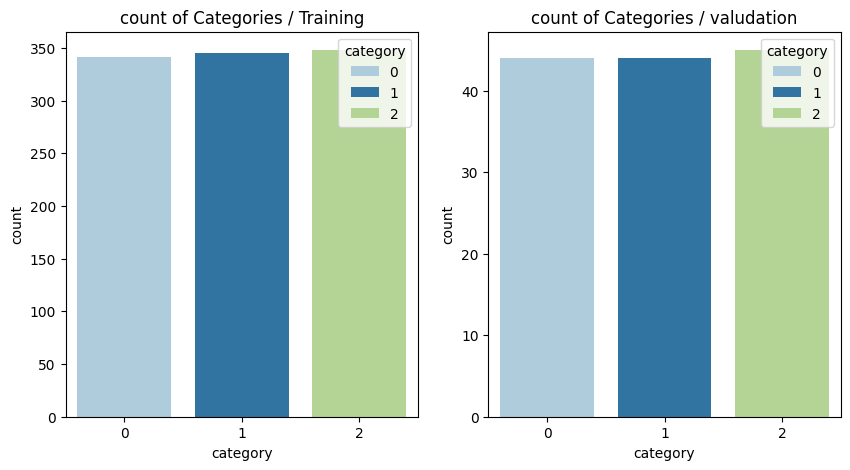

In [9]:
# checking if our data is balanced
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x=train_df['category'],hue=train_df['category'],palette='Paired')
plt.title('count of Categories / Training')
plt.subplot(1,2,2)
sns.countplot(x=val_df['category'],hue=val_df['category'],palette='Paired')
plt.title('count of Categories / valudation')

# we can see that our data is balanced and the categories are distributed evenly .

### **Data preprocessing**

In [10]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [11]:

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)])

class Custom_data(Dataset):
  def __init__(self,dataframe,transform):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(self.dataframe['category']).to(device)

  def __len__(self):
      return self.dataframe.shape[0]

  def __getitem__(self,idx):
      img_path = self.dataframe.iloc[idx, 0]
      label = self.labels[idx]
      image = Image.open(img_path)
      if self.transform:
        image = self.transform(image).to(device)
        return image , label


In [12]:
train_data = Custom_data(train_df, transform)
val_data = Custom_data(val_df, transform)

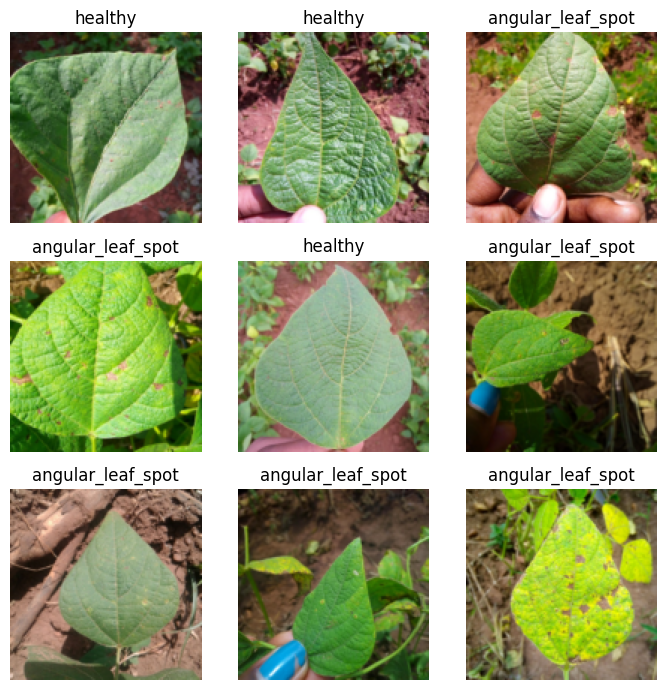

In [13]:
labels = {0:"healthy",
          1:"angular_leaf_spot",
          2:"angular_leaf_spot"}

rows = 3
cols = 3
f, ax = plt.subplots(rows, cols, figsize=(7, 7))
ax = ax.flatten()

for i in range(rows * cols):
    idx = np.random.randint(0, len(train_data))
    image, label = train_data.__getitem__(idx)
    image = image.permute(1, 2, 0).cpu().numpy()
    ax[i].imshow(image)
    ax[i].set_title(labels[label.item()])
    ax[i].axis('off')

plt.tight_layout()
plt.show()


### **building the model**

In [14]:
lr = 1e-3
BATCH_SiZE = 4
EPOCHS = 15


In [22]:
train_loader = DataLoader(train_data,batch_size=BATCH_SiZE,shuffle=True)
val_loader = DataLoader(val_data,batch_size=val_data.__len__(),shuffle=True)

In [16]:
google_net = models.googlenet(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 40.0MB/s]


In [17]:
for param in google_net.parameters():
  # allowing the model to learn again
  param.requires_grad = True


In [18]:
# our model expect a tensor of size 1024 and it ouputs 1000 probability so we need to change that to fit our data
google_net.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [26]:
train_data()

TypeError: 'Custom_data' object is not callable

In [21]:
num_class = len(train_df['category'].unique())
google_net.fc = torch.nn.Linear(google_net.fc.in_features,num_class)
google_net.fc
google_net.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [31]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(google_net.parameters(),lr=lr)

t_train_loss = []
t_train_acc = []

for ep in range (EPOCHS):
  total_loss_train = 0
  total_acc_train = 0
  for input , label in train_loader :
    optimizer.zero_grad()
    preds = google_net(input)

    loss = loss_fun(preds,label)
    total_loss_train += loss.item()

    loss.backward()

    acc = (torch.argmax(preds,axis=1) == label).sum().item()
    total_acc_train += acc

    optimizer.step()
  t_train_loss.append(round(total_loss_train/1000,4))
  t_train_acc.append(round(total_acc_train/train_data.__len__()*100,4))

  print(f"epoch : {ep} | training loss : {round(total_loss_train/1000,4)} | training accuracy : {round(total_acc_train/train_data.__len__()*100,4)} %")



epoch : 0 | training loss : 0.2089 | training accuracy : 65.4739 %
epoch : 1 | training loss : 0.1731 | training accuracy : 73.6944 %
epoch : 2 | training loss : 0.1432 | training accuracy : 79.4004 %
epoch : 3 | training loss : 0.1181 | training accuracy : 83.3656 %
epoch : 4 | training loss : 0.1244 | training accuracy : 82.5919 %
epoch : 5 | training loss : 0.0909 | training accuracy : 87.1373 %
epoch : 6 | training loss : 0.0792 | training accuracy : 89.0716 %
epoch : 7 | training loss : 0.0722 | training accuracy : 90.7157 %
epoch : 8 | training loss : 0.0786 | training accuracy : 88.4913 %
epoch : 9 | training loss : 0.0597 | training accuracy : 92.2631 %
epoch : 10 | training loss : 0.062 | training accuracy : 91.4894 %
epoch : 11 | training loss : 0.0451 | training accuracy : 94.294 %
epoch : 12 | training loss : 0.0324 | training accuracy : 95.8414 %
epoch : 13 | training loss : 0.068 | training accuracy : 91.7795 %
epoch : 14 | training loss : 0.0646 | training accuracy : 91.

In [ ]:
preds_1 = google_net(val_data[input])

In [44]:
import torch
from sklearn.metrics import classification_report , confusion_matrix

# Put the model in evaluation mode
google_net.eval()

# Convert val_data to a DataLoader if it is not already (assuming val_data is not a DataLoader)
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)  # Use the whole dataset at once

all_preds = []
all_labels = []

with torch.no_grad():  # Disables gradient computation for efficiency
    for inputs, labels in val_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = google_net(inputs)
        preds = torch.argmax(outputs, dim=1)

        # Append predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
repport = classification_report(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
print(repport)


              precision    recall  f1-score   support

           0       1.00      0.80      0.89        44
           1       0.97      0.75      0.85        44
           2       0.70      1.00      0.83        45

    accuracy                           0.85       133
   macro avg       0.89      0.85      0.85       133
weighted avg       0.89      0.85      0.85       133



Text(0.5, 23.52222222222222, 'prediction data')

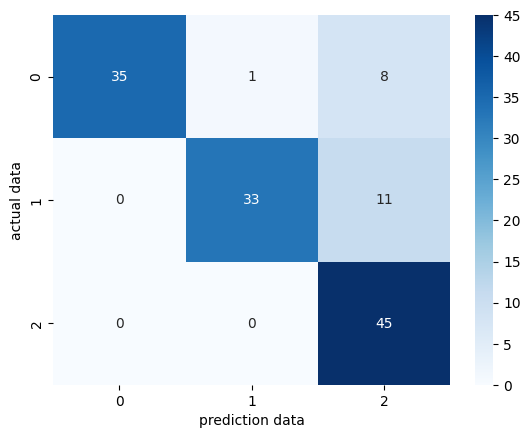

In [46]:
sns.heatmap(conf_matrix,cmap='Blues',annot=True)
plt.ylabel("actual data")
plt.xlabel("prediction data")